In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

#### BatteryManager Processer script

In [37]:
HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def preprocess_values(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    # conversion from microseconds to seconds
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    # df.to_csv('test-paul-controls-bs3/batterymanager.csv', index=False)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = preprocess_values(df)
    df = calculate_power(df)
    # print(RAW_DATA)
    # print("Energy (J) = ", trapezoid_method(df))
    # print('Data path ', data_path.strip('.log') + '.csv')
    df.to_csv('.\\' + data_path.strip('.log') + '.csv', index=False)
    return df

def choose_repetition_type(repetition):
    if 'baseline' in repetition:
        return 'baseline'
    elif 'replay' in repetition:
        return 'replay'
    return 'record'

def set_run_number(repetition):
    return repetition.strip(choose_repetition_type(repetition))

def process_BM(folder):

    folder_num = len(folder.split('\\'))

    df_aggregated = pd.DataFrame(columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            if (folder in root) and (name == 'battery_manager.log'):
                print(os.path.join(root, name))
                energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                device = root.split('\\')[1 + folder_num]
                app = root.split('\\')[2 + folder_num].strip('-W')
                app_details = root.split('\\')[3 + folder_num]
                is_record = choose_repetition_type(root.split('\\')[4 + folder_num])
                is_wireless = '-W' in root.split('\\')[2 + folder_num]
                repetition = set_run_number(root.split('\\')[4 + folder_num])
                df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])

    # normalized energy consumption for better comparison
    df_aggregated['Energy per Second (J/s)'] = df_aggregated['energy(J)'] / df_aggregated['length(s)']
    return df_aggregated

In [38]:
process_BM('swap-vr')

.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.5\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.6\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.7\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.8\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.9\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\2468317632.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,Quest-2,BeatSaber,PopStars-Medium,record,False,0,1732.962997,270.443,6.407868
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.0,1688.840996,261.164,6.466592
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.1,1682.053448,260.044,6.468342
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.2,1671.382607,259.885,6.431239
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.3,1692.866190,260.816,6.490653
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.4,1680.322262,260.760,6.443942
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.5,1679.735849,260.704,6.443077
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.6,1706.195446,260.682,6.545122
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.7,1705.864128,260.656,6.544504
0,Quest-2,BeatSaber,PopStars-Medium,replay,False,0.8,1680.016844,260.624,6.446133


In [39]:
bm = process_BM('overhead-validation').reset_index(drop=True)
# bm.to_csv('overall_energy.csv', index=False)

.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\overhead-validation\Quest-2\BeatSaber\PopStars-Medium\repl

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\2468317632.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay0.5\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay0.6\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay0.7\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay0.8\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay0.9\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\overhead-validation\Quest-Pro\

In [40]:
bm

,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,Quest-2,BeatSaber,PopStars-Medium,baseline,False,0,1637.629356,260.211,6.293467
1,Quest-2,BeatSaber,PopStars-Medium,baseline,False,1,1646.405497,258.065,6.379809
2,Quest-2,BeatSaber,PopStars-Medium,baseline,False,2,1614.135229,255.879,6.308197
3,Quest-2,BeatSaber,PopStars-Medium,record,False,0,1605.080273,256.239,6.263997
4,Quest-2,BeatSaber,PopStars-Medium,record,False,1,1617.171011,257.057,6.291099
...,...,...,...,...,...,...,...,...,...
67,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.5,1636.892353,277.125,5.906693
68,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.6,1605.473918,272.993,5.881008
69,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.7,1612.792951,273.933,5.887545
70,Quest-Pro,BeatSaber,PopStars-Medium,replay,False,2.8,1611.205237,274.862,5.861870


# Plots

### Setting Figure Style

In [41]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                #create dashes next to ticks
                 "xtick.bottom": True,
                 "ytick.left": True,
                
                 "axes.edgecolor": "black",

                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray",
                 
                 }
# custom_params = {}

sns.set_theme(style="whitegrid", rc=custom_params)
sns.set_palette("deep")

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

### Totals per device

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1371000046.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, palette='colorblind')


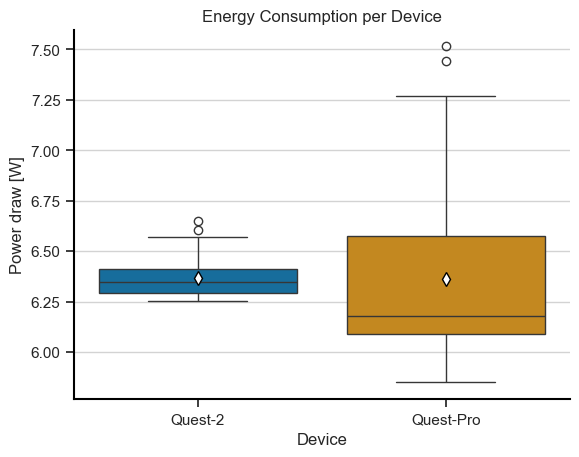

In [42]:
sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, palette='colorblind')
plt.ylabel('Power draw [W]')
plt.xlabel('Device')
plt.title('Energy Consumption per Device')
plt.show()

### Energy Consumption per Device and App

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1968020714.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='Energy per Second (J/s)', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1968020714.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='Energy per Second (J/s)', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')


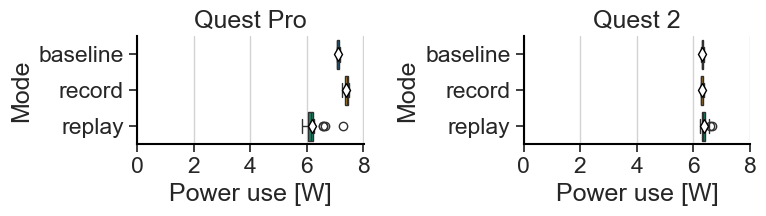

Quest 2 baseline avg 6.327157913530805 W
Quest 2 record avg 6.310491307737119 W
Quest 2 replay avg 6.377087534834221 W
Quest Pro baseline avg 7.106367051734549 W
Quest Pro record avg 7.400603999367426 W
Quest Pro replay avg 6.184493389137716 W
Quest Pro max diff 1.2161106102297108 W
Quest 2 max diff 0.06659622709710167 W


In [43]:

def plot_apps_by_device(df, out_folder):
    unique_devices = ['Quest-Pro', 'Quest-2']
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(8, 2.5))
    min_energy = df['Energy per Second (J/s)'].min() - 0.5
    max_energy = df['Energy per Second (J/s)'].max() + 0.5
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        # sns.set_style("whitegrid", {'axes.grid' : True, 'grid.color': '0.5'})
        sns.boxplot(data=df[df['device'] == device], x='Energy per Second (J/s)', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
        
        # ax.set_facecolor("white")
        # ax.spines['bottom'].set_color('0.5')
        # ax.spines['top'].set_color(None)
        # ax.spines['right'].set_color(None)
        # ax.spines['left'].set_color('0.5')
        
        ax.set_xlabel('Power use [W]')
        ax.set_ylabel('Mode')
        ax.set_xticks([0,2,4,6,8])
        ax.set_title(device.replace('-', ' '))

        ax.set_xlim(0, max_energy)
    
    # fig.suptitle('Energy Consumption Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/val_energy.pdf', bbox_inches='tight', format='pdf')
    plt.show()

# sns.set(font_scale=1.5)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)
plot_apps_by_device(bm, 'validation')

# find min and max average energy consumption per record per device
print('Quest 2 baseline avg', bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 record avg', bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 replay avg', bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro baseline avg', bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro record avg', bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest Pro replay avg', bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean(), 'W')

quest_pro_max_diff = bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean() - bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-Pro')]['Energy per Second (J/s)'].mean()
print('Quest Pro max diff', quest_pro_max_diff, 'W')
quest_2_max_diff = bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean() - bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean()
print('Quest 2 max diff', quest_2_max_diff, 'W')

In [44]:
bm = bm[bm['app'] != 'PistolWhip']

In [45]:
def plot_traces_per_device(df, device):
    df = df[df['device'] == device]
    unique_apps = df['is_wireless'].unique()
    num_apps = len(unique_apps)
    fig, axes = plt.subplots(1, num_apps, figsize=(5.25*num_apps, 7))
    min_energy = df['Energy per Second (J/s)'].min() - 0.5
    max_energy = df['Energy per Second (J/s)'].max() + 0.5    
    
    for i, wireless in enumerate(unique_apps):
        ax = axes[i]
        sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
        if wireless:
            ax.set_title('Energy Consumption of Wireless Traces on ' + device)
        else:
            ax.set_title('Energy Consumption of Cabled Traces on ' + device)
        ax.set_ylabel('Power use [W]')
        ax.set_xlabel('Trace')

        ax.set_ylim(0, max_energy)
    fig.suptitle('Energy Consumption of Traces on ' + device)
    plt.tight_layout()
    plt.show()

sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

# plot_traces_per_device(bm, 'Quest-2')
# plot_traces_per_device(bm, 'Quest-Pro')

.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.1\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.2\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.3\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.4\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.5\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.6\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.7\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.8\battery_manager.log
.\swap-vr\Quest-2\BeatSaber\PopStars-Medium\replay0.9\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars-Medium\record0\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars-Medium\replay0.0\battery_manager.log
.\swap-vr\Quest-Pro\BeatSaber\PopStars

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\2468317632.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1968020714.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='Energy per Second (J/s)', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax,

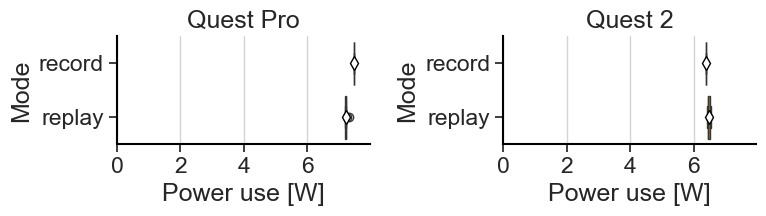

Quest 2 PC-B baseline avg 6.327157913530805 W
Quest 2 PC-B record avg 6.310491307737119 W
Quest 2 PC-B replay avg 6.377087534834221 W
Quest 2 PC-A record avg 6.407867818896804 W
Quest 2 PC-A replay avg 6.481947396179848 W
Quest 2 setup max diff 0.17145608844272875 W


In [46]:
swap_bm = process_BM('swap-vr').reset_index(drop=True)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

plot_apps_by_device(swap_bm, 'swap')

print('Quest 2 PC-B baseline avg', bm[(bm['is_record'] == 'baseline') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 PC-B record avg', bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 PC-B replay avg', bm[(bm['is_record'] == 'replay') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')

print('Quest 2 PC-A record avg', swap_bm[(swap_bm['is_record'] == 'record') & (swap_bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')
print('Quest 2 PC-A replay avg', swap_bm[(swap_bm['is_record'] == 'replay') & (swap_bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean(), 'W')

q2_setup_max_diff = swap_bm[(swap_bm['is_record'] == 'replay') & (swap_bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean() - bm[(bm['is_record'] == 'record') & (bm['device'] == 'Quest-2')]['Energy per Second (J/s)'].mean()
print('Quest 2 setup max diff', q2_setup_max_diff, 'W')

## CPU GPU Validation

In [47]:

def get_cpu_gpu_data(path, folder_num):
    df = pd.DataFrame(columns=['device', 'app', 'is_record', 'repetition', 'timestamp_cpu', 'timestamp_gpu', 'cpu_usage', 'gpu_usage'])
    df['gpu_usage'] = pd.read_csv(path)['memoryUtil']
    df['timestamp_gpu'] = pd.read_csv(path)['timestamp']

    cpu_path = path.replace('host_gpu_metrics.log', 'host_sys_metrics.log')
    df['cpu_usage'] = pd.read_csv(cpu_path)['cpu.percent']
    df['timestamp_cpu'] = pd.read_csv(cpu_path)['timestamp']

    df['device'] = path.split('\\')[1 + folder_num]
    df['app'] = path.split('\\')[2 + folder_num].strip('-W')
    df['is_record'] = choose_repetition_type(path.split('\\')[4 + folder_num])
    df['repetition'] = set_run_number(path.split('\\')[4 + folder_num])
    
    return df


def process_cpu_gpu(folder):

    folder_num = len(folder.split('\\'))

    df_aggregated = pd.DataFrame(columns=['device', 'app', 'is_record', 'repetition', 'timestamp_cpu', 'timestamp_gpu', 'cpu_usage', 'gpu_usage'])
    for root, dirs, files in os.walk(".", topdown=False):
        for file in files:
            if (folder in root):
                if file == 'host_gpu_metrics.log':
                    path = os.path.join(root, file)
                    temp = get_cpu_gpu_data(path, folder_num)
                    df_aggregated = pd.concat([df_aggregated, temp])
                    
                # print(os.path.join(root, name))
                
    # normalized energy consumption for better comparison
    # df_aggregated['Energy per Second (J/s)'] = df_aggregated['energy(J)'] / df_aggregated['length(s)']
    df_aggregated['gpu_usage'] = df_aggregated['gpu_usage'] * 100
    return df_aggregated

wa = process_cpu_gpu('overhead-validation')

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\863157488.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, temp])


In [48]:
sns.set(font_scale=1.5)

def plot_gpu_usage(df, out_folder):
    unique_devices = df['device'].unique()[:2]
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(8, 2.5))
    min_energy = df['gpu_usage'].min() - 0.5
    max_energy = df['gpu_usage'].max() + 5
    unique_devices = reversed(unique_devices)
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        sns.boxplot(data=df[df['device'] == device], x='gpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
        ax.set_xlabel('GPU usage [%]')
        ax.set_ylabel('Mode')
        cmp = 'Quest-2'
        if 'swap' in out_folder:
            cmp = 'Quest-Pro'

        if device == cmp:
            ax.set_title("PC-B (running " + device.replace("-", " ") + ")")
        else:
            ax.set_title("PC-A (running " + device.replace("-", " ") + ")")
        
        ax.set_xticks([0,10,20,30,40,50])

        ax.set_xlim(0, max_energy)
    
    # fig.suptitle('GPU usage Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/val_gpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()


def plot_cpu_usage(df, out_folder):
    unique_devices = df['device'].unique()[:2]
    num_devices = len(unique_devices)
    fig, axes = plt.subplots(1, num_devices, figsize=(8, 2.5))
    min_energy = df['cpu_usage'].min() - 0.5
    max_energy = df['cpu_usage'].max() + 5
    unique_devices = reversed(unique_devices)
    
    for i, device in enumerate(unique_devices):
        ax = axes[i]
        sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='deep')
        ax.set_xlabel('CPU usage [%]')
        ax.set_ylabel('Mode')
        cmp = 'Quest-2'
        if 'swap' in out_folder:
            cmp = 'Quest-Pro'

        if device == cmp:
            ax.set_title("PC-B (running " + device.replace("-", " ") + ")")
        else:
            ax.set_title("PC-A (running " + device.replace("-", " ") + ")")
        
        ax.set_xticks([0,10,20,30,40,50])
        
        ax.set_xlim(0, max_energy)
    
    # fig.suptitle('CPU usage Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/val_cpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1063945148.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='deep')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1063945148.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='deep')


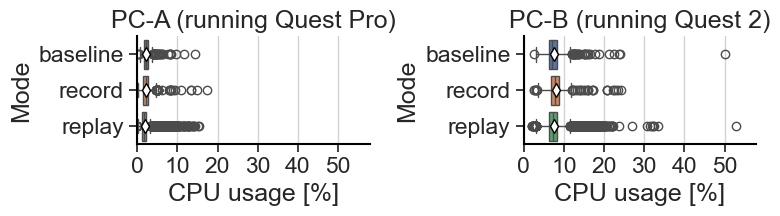

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1063945148.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='gpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1063945148.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='gpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')


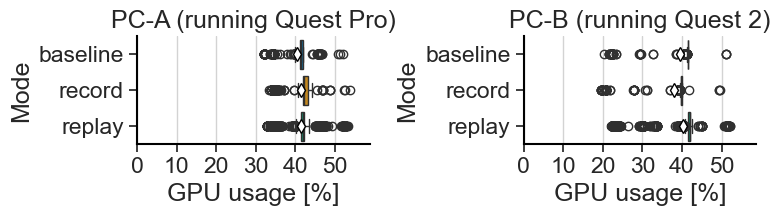

In [49]:
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

plot_cpu_usage(wa, 'validation')
plot_gpu_usage(wa, 'validation')

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\863157488.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, temp])
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1063945148.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='gpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1063945148.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` vari

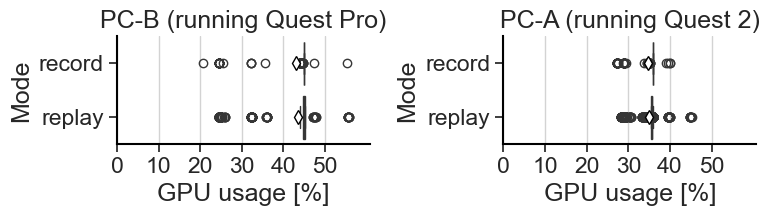

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1063945148.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='deep')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\1063945148.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['device'] == device], x='cpu_usage', y='is_record', showmeans=True, meanprops=custom_mean, ax=ax, palette='deep')


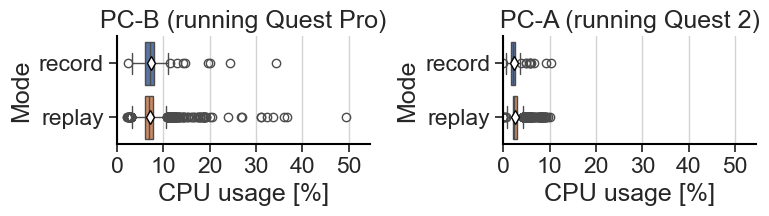

In [50]:
swap = process_cpu_gpu('swap-vr')
plot_gpu_usage(swap, 'swap')
plot_cpu_usage(swap, 'swap')


In [59]:
q2_bl = wa[(wa['device'] == 'Quest-2') & (wa['is_record'] == 'baseline')]['gpu_usage'].describe()
q2_rec = wa[(wa['device'] == 'Quest-2') & (wa['is_record'] == 'record')]['gpu_usage'].describe()
q2_rep = wa[(wa['device'] == 'Quest-2') & (wa['is_record'] == 'replay')]['gpu_usage'].describe()

qp_bl = wa[(wa['device'] == 'Quest-Pro') & (wa['is_record'] == 'baseline')]['gpu_usage'].describe()
qp_rec = wa[(wa['device'] == 'Quest-Pro') & (wa['is_record'] == 'record')]['gpu_usage'].describe()
qp_rep = wa[(wa['device'] == 'Quest-Pro') & (wa['is_record'] == 'replay')]['gpu_usage'].describe()

print('Quest 2 bl diff', q2_bl['75%'] - q2_bl['25%'])
print('Quest 2 rec diff', q2_rec['75%'] - q2_rec['25%'])
print('Quest 2 rep diff', q2_rep['75%'] - q2_rep['25%'])

print('Quest Pro bl diff', qp_bl['75%'] - qp_bl['25%'])
print('Quest Pro rec diff', qp_rec['75%'] - qp_rec['25%'])
print('Quest Pro rep diff', qp_rep['75%'] - qp_rep['25%'])

print('Quest 2 min, max gpu usage', wa[(wa['device'] == 'Quest-2')]['gpu_usage'].min(), wa[(wa['device'] == 'Quest-2')]['gpu_usage'].max())
print('Quest Pro min, max gpu usage', wa[(wa['device'] == 'Quest-Pro')]['gpu_usage'].min(), wa[(wa['device'] == 'Quest-Pro')]['gpu_usage'].max())

Quest 2 bl diff 0.13841393909787314
Quest 2 rec diff 0.1709819247679647
Quest 2 rep diff 0.5862237420615557
Quest Pro bl diff 0.80078125
Quest Pro rec diff 1.19140625
Quest Pro rep diff 0.78125
Quest 2 min, max gpu usage 19.46751343429409 52.11691906855561
Quest Pro min, max gpu usage 32.119140625 53.7109375


# Swap figures redo

In [52]:
wa['experiment'] = 'validation'
# wa[host machine] is PC-A if the device is Quest-Pro
wa['host_machine'] = ['PC-A' if device == 'Quest-Pro' else 'PC-B' for device in wa['device']]

swap['experiment'] = 'swap'
swap['host_machine'] = ['PC-A' if device == 'Quest-2' else 'PC-B' for device in swap['device']]


full_df = pd.concat([wa, swap])

In [53]:
# Convert is_record to boolean


C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='gpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

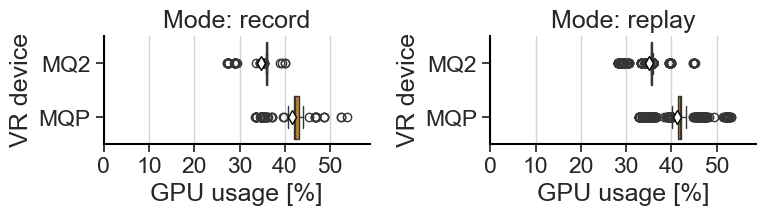

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='cpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

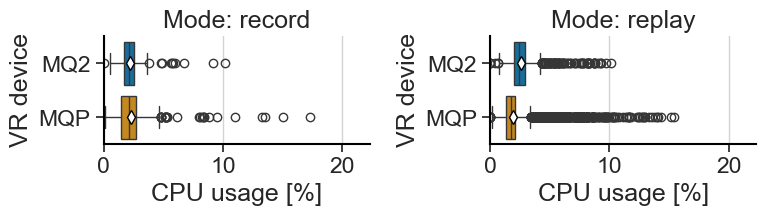

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='gpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

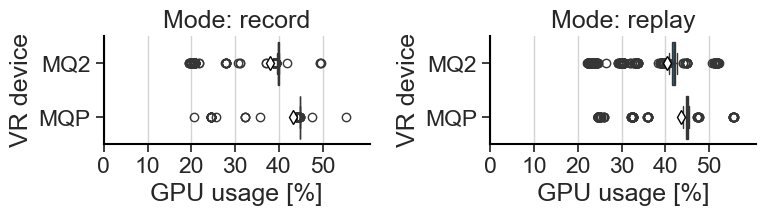

C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='cpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
C:\Users\radua\AppData\Local\Temp\ipykernel_25216\547583134.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

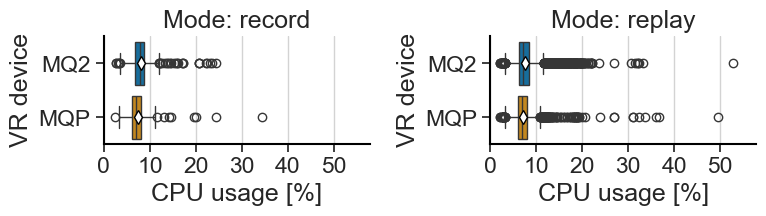

In [54]:
def plot_gpu_usage_pc(df, out_folder):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
    min_energy = df['gpu_usage'].min() - 0.5
    max_energy = df['gpu_usage'].max() + 5
    is_record_list = ['record', 'replay']
    df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')

    
    for i, rec in enumerate(is_record_list):
        ax = axes[i]
        sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='gpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
        ax.set_xlabel('GPU usage [%]')
        ax.set_ylabel('VR device')

        ax.set_title('Mode: ' + rec)
        
        ax.set_xticks([0,10,20,30,40,50])

        ax.set_xlim(0, max_energy)
    
    host_machine = df['host_machine'].unique()[0]
    # fig.suptitle('GPU usage Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/{host_machine}_device_vs_gpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()


def plot_cpu_usage_pc(df, out_folder):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
    min_energy = df['cpu_usage'].min() - 0.5
    max_energy = df['cpu_usage'].max() + 5
    is_record_list = ['record', 'replay']
    df['device'] = df['device'].apply(lambda x: 'MQ2' if x == 'Quest-2' else 'MQP')
    
    for i, rec in enumerate(is_record_list):
        ax = axes[i]
        sns.boxplot(data=df[df['is_record'] == rec].sort_values(by='device'), x='cpu_usage', y='device', showmeans=True, meanprops=custom_mean, ax=ax, palette='colorblind')
        ax.set_xlabel('CPU usage [%]')
        ax.set_ylabel('VR device')

        ax.set_title('Mode: ' + rec)
        
        ax.set_xticks([0,10,20,30,40,50])

        ax.set_xlim(0, max_energy)
    
    host_machine = df['host_machine'].unique()[0]
    # fig.suptitle('CPU usage Comparison')
    plt.tight_layout()
    plt.savefig(f'./figures/{out_folder}/{host_machine}_device_vs_cpu.pdf', bbox_inches='tight', format='pdf')
    plt.show()



plot_gpu_usage_pc(full_df[full_df['host_machine'] == 'PC-A'], 'swap')
plot_cpu_usage_pc(full_df[full_df['host_machine'] == 'PC-A'], 'swap')

plot_gpu_usage_pc(full_df[full_df['host_machine'] == 'PC-B'], 'swap')
plot_cpu_usage_pc(full_df[full_df['host_machine'] == 'PC-B'], 'swap')

# Statistical test for GPU utilization

In [55]:
gpu_rec_pca_2 = full_df[(full_df['host_machine'] == 'PC-B') & (full_df['is_record'] == 'replay') & (full_df['device'] == 'Quest-2')]['gpu_usage']
gpu_rec_pca_pro = full_df[(full_df['host_machine'] == 'PC-B') & (full_df['is_record'] == 'replay') & (full_df['device'] == 'Quest-Pro')]['gpu_usage']

# check if gpu usage is normally distributed
from scipy.stats import shapiro
print(shapiro(gpu_rec_pca_2))
print(shapiro(gpu_rec_pca_pro))


# t test for significance
from scipy.stats import ttest_ind
print(ttest_ind(gpu_rec_pca_2, gpu_rec_pca_pro, equal_var=False))


ShapiroResult(statistic=0.4206128871934536, pvalue=3.35828330584522e-94)
ShapiroResult(statistic=0.364501610799447, pvalue=1.2261999983565746e-72)
TtestResult(statistic=-28.43426393699137, pvalue=5.77151335901889e-166, df=5457.001546820328)


C:\Users\radua\AppData\Local\Temp\ipykernel_25216\3249755286.py:6: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7661.
  print(shapiro(gpu_rec_pca_2))
